In [3]:
# Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

# Imports and Functions

## Imports and Constants

In [4]:
import os
import pickle
import shutil
import sys
import threading
import time
import gc
import random
from datetime import datetime
from functools import reduce
from io import BytesIO
from itertools import combinations, product
from operator import mul

In [5]:
import boto3
import iris
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import scipy
import seaborn as sns
from joblib import Parallel, delayed, parallel_backend
from scipy.spatial.distance import hamming
from scipy.stats import ks_2samp, ttest_ind
from scipy.optimize import root_scalar

In [6]:
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
    int_distance
)
from iris_pairwise_min_dist_calculation import get_pairwise_min_dist_across_rotations

In [7]:
n_jobs = 6 # Fit to CPU
DIM = (2, 32, 200)

## General Functions

In [8]:
last_update_time = time.time()
def print_progress(msg, delay=1, force_print=False):
    global last_update_time
    if (time.time() - last_update_time > delay) or force_print:
        sys.stdout.write('\r' + ' ' * 200)
        sys.stdout.write(f"\r{msg}")
        sys.stdout.flush()
        
        last_update_time = time.time()

def save_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
    print(f"Object successfully saved to {filename}")

def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    print(f"Object successfully loaded from {filename}")
    return obj

In [9]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [10]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

## Loading Functions

In [11]:
def read_partial_file(filename, num_bits):
    num_bytes = (num_bits + 7) // 8  # Ensure we round up if num_bits isn't a multiple of 8
    with open(filename, 'rb') as f:
        chunk = f.read(num_bytes)
    return np.frombuffer(chunk, dtype=np.uint8)

In [12]:
def load_and_reshape_masks(filename, num_masks, DIM=DIM):
    flattened_data = np.unpackbits(read_partial_file(filename, ((DIM[1]//2) * DIM[2]) * num_masks))
    boolean_arrays = flattened_data.reshape((num_masks, DIM[1]//2, DIM[2]))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

In [13]:
def load_and_reshape_irises(path_low, path_high, num_samples, DIM=DIM):
    low_high_lst = [
        np.unpackbits(
            read_partial_file(path, (reduce(mul, DIM[1:]) * num_samples)), bitorder="little"
        ).reshape(num_samples, *DIM[1:]) for path in [path_low, path_high]
    ]
    return np.concatenate(low_high_lst, axis=1).astype(bool)

## Test Functions and DB Buildup 

In [14]:
def update_db(db, iris_df, db_size, force_layer=None):
    db_current_size = db.get_stats()['db_size']
    if (db_size - db_current_size) <= 0:
        return
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for i, iris in enumerate(new_irises):
        print_progress(f'Currently building {int_to_scaled_string(db_size)} DB, with M={db.M}, efConstruction={db.efConstruction}. Insertion Progress: {(i+1)/len(new_irises):.1%}')
        db.insert(make_query(iris), insert_layer=force_layer)
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [15]:
def numpy_array_to_iris_df(iris_array, mask_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(iris), list(mask)) for iris, mask in zip(iris_array, mask_array))
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [16]:
def run_single_experiment(db, idx, iris, noise, efSearch, K):
    noisy_query = make_query(iris_with_noise(iris, noise_level=noise))
    res = db.search(noisy_query, K, ef=efSearch)
    return any(idx == tup[1] for tup in res)

# Data Loading

## Configurations

In [15]:
synthetic_data_size = 2**22
max_tested_db_size = 200000

In [16]:
path_masks = f'synthetic_data/{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = 'synthetic_data/2_23_voter_arrays_90k_b090.dat'
path_iris_high = 'synthetic_data/2_23_voter_arrays_14k_b010.dat'

## Loading

In [17]:
loaded_masks = load_and_reshape_masks(path_masks, max_tested_db_size).astype(bool)
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, max_tested_db_size)

## Reassuring stats

In [18]:
assert len(loaded_masks) == max_tested_db_size
assert len(loaded_irises) == max_tested_db_size
print(f'Successfuly loaded {int_to_scaled_string(max_tested_db_size)} masks and irises')

Successfuly loaded 200K masks and irises


# Expected Layer Sizes

In [17]:
def p_k(k, m_L):
    return np.exp(-k/m_L) - np.exp(-(k+1)/m_L)

In [33]:
N = 100000
for M in np.arange(16, 129, 16):
    m_L = 1/np.log(M)
    layers_expected_sizes = [str(int(np.round(N*p_k(k, m_L)))) for k in range(7)]
    print(f'Given M={M}, DB Size={int_to_scaled_string(N)}, The Expected Layer Sizes are: {", ".join(layers_expected_sizes)}')

Given M=16, DB Size=100K, The Expected Layer Sizes are: 93750, 5859, 366, 23, 1, 0, 0
Given M=32, DB Size=100K, The Expected Layer Sizes are: 96875, 3027, 95, 3, 0, 0, 0
Given M=48, DB Size=100K, The Expected Layer Sizes are: 97917, 2040, 42, 1, 0, 0, 0
Given M=64, DB Size=100K, The Expected Layer Sizes are: 98438, 1538, 24, 0, 0, 0, 0
Given M=80, DB Size=100K, The Expected Layer Sizes are: 98750, 1234, 15, 0, 0, 0, 0
Given M=96, DB Size=100K, The Expected Layer Sizes are: 98958, 1031, 11, 0, 0, 0, 0
Given M=112, DB Size=100K, The Expected Layer Sizes are: 99107, 885, 8, 0, 0, 0, 0
Given M=128, DB Size=100K, The Expected Layer Sizes are: 99219, 775, 6, 0, 0, 0, 0


In [35]:
N = 1000000
for m_L in np.linspace(0.3, 0.7, 21):
    layers_expected_sizes = [str(int(np.round(N*p_k(k, m_L)))) for k in range(7)]
    print(f'Given m_L={m_L:.2f}, DB Size={int_to_scaled_string(N)}, The Expected Layer Sizes are: {", ".join(layers_expected_sizes)}')

Given m_L=0.30, DB Size=1M, The Expected Layer Sizes are: 964326, 34401, 1227, 44, 2, 0, 0
Given m_L=0.32, DB Size=1M, The Expected Layer Sizes are: 956063, 42006, 1846, 81, 4, 0, 0
Given m_L=0.34, DB Size=1M, The Expected Layer Sizes are: 947196, 50015, 2641, 139, 7, 0, 0
Given m_L=0.36, DB Size=1M, The Expected Layer Sizes are: 937823, 58311, 3626, 225, 14, 1, 0
Given m_L=0.38, DB Size=1M, The Expected Layer Sizes are: 928035, 66786, 4806, 346, 25, 2, 0
Given m_L=0.40, DB Size=1M, The Expected Layer Sizes are: 917915, 75347, 6185, 508, 42, 3, 0
Given m_L=0.42, DB Size=1M, The Expected Layer Sizes are: 907538, 83913, 7759, 717, 66, 6, 1
Given m_L=0.44, DB Size=1M, The Expected Layer Sizes are: 896969, 92415, 9522, 981, 101, 10, 1
Given m_L=0.46, DB Size=1M, The Expected Layer Sizes are: 886268, 100797, 11464, 1304, 148, 17, 2
Given m_L=0.48, DB Size=1M, The Expected Layer Sizes are: 875486, 109011, 13573, 1690, 210, 26, 3
Given m_L=0.50, DB Size=1M, The Expected Layer Sizes are: 86466

# efConstruction Analysis

## Configurations

In [50]:
M = 16
db_size = 50000
efConstruction_range = np.arange(8, 33, 8)
layer_1_sizes = [0, 2500, 5000, 10000]
K = 1

In [51]:
assert db_size <= max_tested_db_size

In [52]:
num_experiments = 1000
noise_level = 0.2

## Search-log Testing

In [53]:
def process_search_log(search_log):
    search_log_df = pd.DataFrame(search_log, index=['step', 'depth', 'eq', 'fq', 'lc']).T.reset_index().rename(columns={'index':'node_id'})
    search_log_df['total_num_steps'] = len(search_log_df)
    search_log_df = search_log_df[search_log_df['step'] <= search_log_df['eq'].argmin()]
    search_log_df['step'], search_log_df['depth'] = search_log_df['step'].astype(int), search_log_df['depth'].astype(int)
    search_log_df['search_progress'] = search_log_df['eq'].cummin()
    search_log_df['single_step_progress'] = search_log_df['search_progress'].diff(periods=-1)
    return search_log_df

In [54]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)

In [55]:
num_experiments, df_list = 1000, []
for efConstruction in efConstruction_range:
    db = hnsw.HNSW(
        M=M, 
        efConstruction=efConstruction, 
        m_L=1/np.log(M), 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    db.record_search_log = True
    iris_df['Inserted'] = False
    update_db(db, iris_df, db_size, force_layer=0)
    
    for layer_1_size in layer_1_sizes:
        update_db(db, iris_df, db_size+layer_1_size, force_layer=1)
        if layer_1_size > 0:
            assert (len(db.layers) == 2) & (len(db.layers[1]) == layer_1_size)
        
        indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values            
        precision_lst = []
        for i in range(num_experiments):
            print_progress(f'efConstruction={efConstruction}, Layer 1 Size={layer_1_size}, Search progress: {(i+1)/(num_experiments+1):.1%}')
            noisy_query = make_query(iris_with_noise(irises[i], noise_level=0.2))
            res = db.search(noisy_query, 1, ef=M)
            precision_lst.append(any(indices[i] == tup[1] for tup in res))
    
            df_list.append(
                process_search_log(db.search_log).assign(
                    experiment = i,
                    efConstruction = efConstruction,
                    layer_1_size = layer_1_size,
                    Recall = np.mean(precision_lst),
                    target_node_id = indices[i],
                )
            )
final_df = pd.concat(df_list, ignore_index=True)

efConstruction=32, Layer 1 Size=10000, Search progress: 99.1%                                                                                                                                           

In [62]:
basic_results = (
    final_df.groupby(['efConstruction', 'layer_1_size', 'experiment'])['Recall']
    .first()
    .reset_index()
    .groupby(['efConstruction', 'layer_1_size'])['Recall']
    .mean()
    .reset_index()
    .rename(columns={'layer_1_size':'Layer 1 Size'})
)

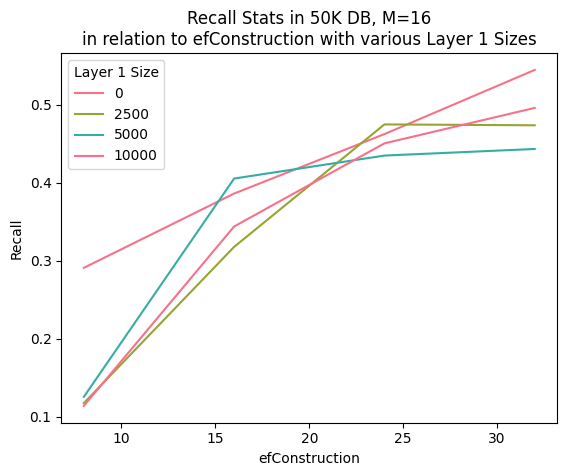

In [82]:
sns.lineplot(basic_results, x='efConstruction', y='Recall', hue='Layer 1 Size', palette='husl')
plt.title(f'Recall Stats in {int_to_scaled_string(db_size)} DB, M={M}\nin relation to efConstruction with various Layer 1 Sizes');

In [76]:
computations = (
    final_df.groupby(['efConstruction', 'layer_1_size', 'experiment'])[['step', 'total_num_steps']]
    .last()
    .reset_index()
    .rename(columns={'layer_1_size':'Layer 1 Size', 'step':'Until Found', 'total_num_steps':'Total'})
    .melt(id_vars=['efConstruction', 'Layer 1 Size', 'experiment'], value_vars=['Until Found', 'Total'], var_name='Steps', value_name='Count')
)

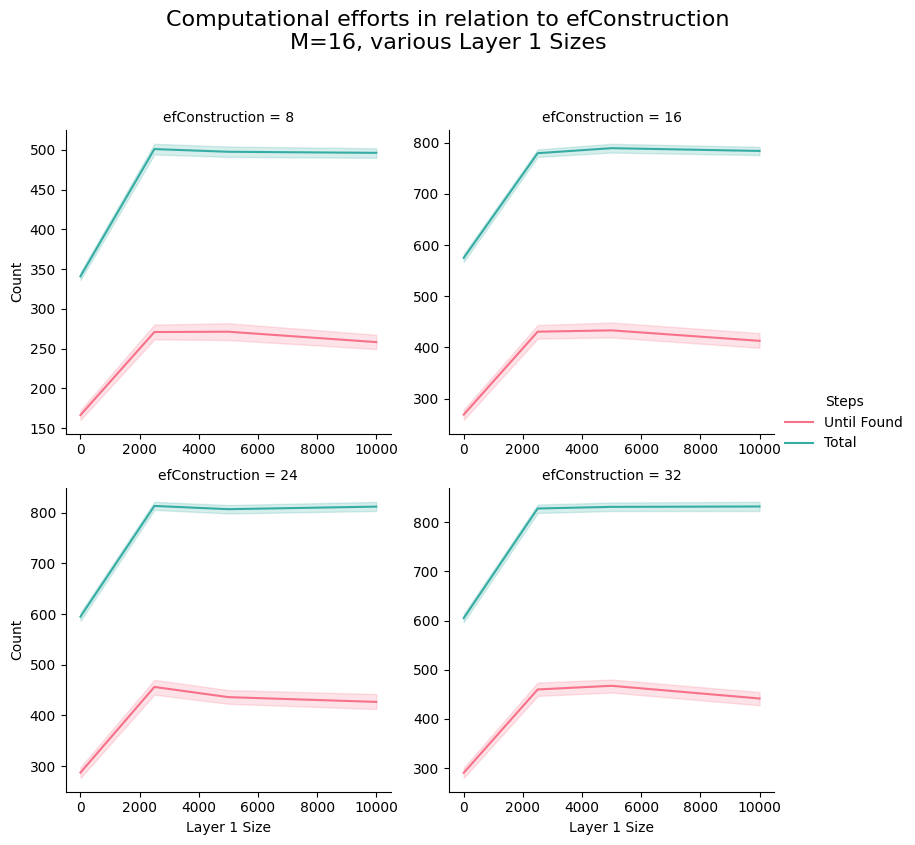

In [124]:
facetgrid = sns.FacetGrid(computations, col='efConstruction', hue='Steps', palette='husl', col_wrap=2, height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x='Layer 1 Size', y='Count')
facetgrid.add_legend()
facetgrid.fig.suptitle(f"Computational efforts in relation to efConstruction\nM={M}, various Layer 1 Sizes", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()

In [87]:
def add_curr_source_node(group):
    sources = np.where(group['single_step_progress'].shift() > 0, group['node_id'], np.nan)
    return pd.Series(data=sources, index=group.index).ffill()

In [103]:
def get_single_experiment_distances_df(group):
    distances_df_lst = []
    for index, (experiment, layer_1_size, curr_source_node, target_node_id, depth) in group.iterrows():
        source_neighbors = [tup[1] for tup in db.layers[0][int(curr_source_node)]]
        distances = [int_distance(db.vectors[int(target_node_id)], db.vectors[neighbor]) for neighbor in source_neighbors]
        distances_df_lst.append(pd.DataFrame({'Distances':distances, 'Depth':depth}))
    return pd.concat(distances_df_lst)

In [99]:
final_df['curr_source_node'] = final_df.groupby(['efConstruction', 'layer_1_size', 'experiment'], group_keys=False).apply(add_curr_source_node)
progress_df = (
    final_df[(final_df['lc'] == 0) & (final_df['efConstruction'] == efConstruction_range.max())]
    .groupby(['layer_1_size', 'experiment', 'curr_source_node'], sort=False)['target_node_id']
    .first()
    .reset_index()
)
progress_df['depth'] = progress_df.groupby(['layer_1_size', 'experiment']).cumcount()

/var/folders/9g/pshnfl_53rv2t0zccy8bcr_m0000gn/T/ipykernel_85512/2747814146.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df['curr_source_node'] = final_df.groupby(['efConstruction', 'layer_1_size', 'experiment'], group_keys=False).apply(add_curr_source_node)


In [112]:
distances_df = (
    progress_df
    .groupby(['experiment', 'layer_1_size'])
    .apply(get_single_experiment_distances_df)
    .droplevel(-1)
    .reset_index()
    .rename(columns={'layer_1_size':'Layer 1 Size'})
)
distances_df = distances_df[distances_df['Distances'] > 0]
distances_df['Depth'] = distances_df['Depth'].astype(int)

/var/folders/9g/pshnfl_53rv2t0zccy8bcr_m0000gn/T/ipykernel_85512/1379666536.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_single_experiment_distances_df)


In [116]:
def plot_hist_with_stats(data, **kwargs):
    sns.histplot(data, x="Distances", stat="probability", kde=True, **kwargs)
    mean, std = data["Distances"].mean(), data["Distances"].std()
    layer_1_size = data['Layer 1 Size'].iloc[0]
    plt.gca().set_title(f"Layer 1 Size = {layer_1_size}\nMean: {mean:.2f}, Std: {std:.2f}")

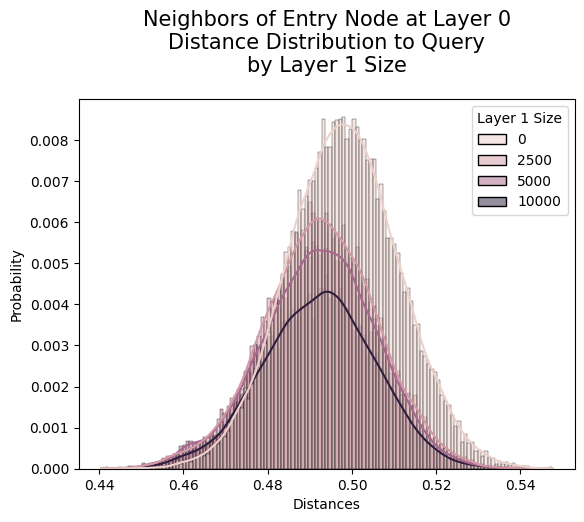

In [122]:
sns.histplot(distances_df[distances_df['Depth'] == 0], x='Distances', hue='Layer 1 Size', stat='probability', kde=True)
plt.title('Neighbors of Entry Node at Layer 0\nDistance Distribution to Query\nby Layer 1 Size', fontsize=15, y=1.05);

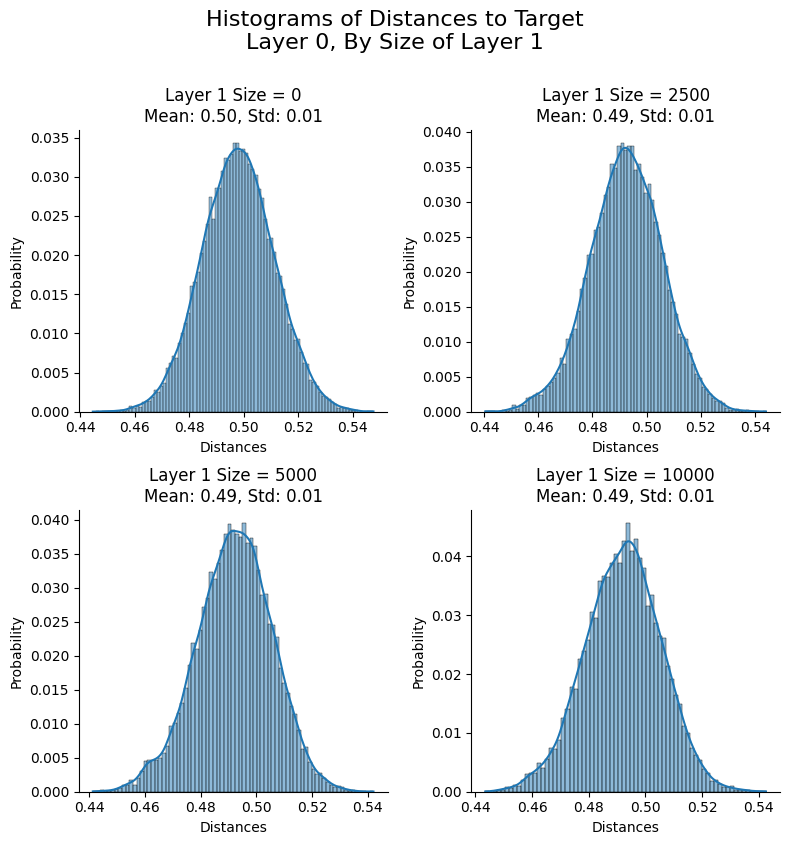

In [123]:
facetgrid = sns.FacetGrid(distances_df[distances_df['Depth'] == 0], col="Layer 1 Size", col_wrap=2, height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(plot_hist_with_stats)
facetgrid.fig.suptitle("Histograms of Distances to Target\nLayer 0, By Size of Layer 1", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()

# efSearch Analysis

## Configurations

In [31]:
M = 64
efConstruction = 64
m_L = 0.5
db_size = 200000
efSearch_range = [32, 64, 128]
noise_range = np.linspace(0.2, 0.45, 11)

In [32]:
assert db_size <= max_tested_db_size

## DB Buildup

In [22]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)

In [23]:
db = hnsw.HNSW(
    M=M, 
    efConstruction=efConstruction, 
    m_L=m_L, 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)

In [24]:
update_db(db, iris_df, db_size)
db.record_search_log = True

Currently building 200K DB, with M=64, efConstruction=64. Insertion Progress: 100.0%                                                                                                                    

## Search-log Testing

In [59]:
def process_search_log(search_log):
    search_log_df = pd.DataFrame(search_log, index=['step', 'depth', 'eq', 'fq', 'lc']).T.reset_index().rename(columns={'index':'node_id'})
    search_log_df['total_num_steps'] = len(search_log_df)
    search_log_df = search_log_df[search_log_df['step'] <= search_log_df['eq'].argmin()]
    search_log_df['step'], search_log_df['depth'] = search_log_df['step'].astype(int), search_log_df['depth'].astype(int)
    search_log_df['search_progress'] = search_log_df['eq'].cummin()
    search_log_df['single_step_progress'] = search_log_df['search_progress'].diff(periods=-1)
    return search_log_df

In [ ]:
num_experiments, df_list = 1000, []
for noise_level, efSearch in product(noise_range, efSearch_range):
    for layer1_efSearch in [1, efSearch]:
        indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values            
        for i in range(num_experiments):
            print_progress(f'Noise Level={noise_level}, efSearch=0:{efSearch}, 1:{layer1_efSearch}, Search progress: {(i+1)/(num_experiments+1):.1%}')
            noisy_query = make_query(iris_with_noise(irises[i], noise_level=noise_level))
            res = db.search(noisy_query, 1, ef={0:efSearch, 1:layer1_efSearch})
            precision = any(indices[i] == tup[1] for tup in res)
    
            df_list.append(
                process_search_log(db.search_log).assign(
                    experiment = i,
                    noise_level = noise_level,
                    efSearch = efSearch,
                    layer1_efSearch = layer1_efSearch,
                    Recall = precision,
                    target_node_id = indices[i],
                )
            )

In [23]:
# final_df = pd.concat(df_list, ignore_index=True)
# final_df.to_parquet("temp_ef_results.parquet")

In [19]:
# final_df = pd.read_parquet("temp_ef_results.parquet")

In [25]:
precision_df = (
    final_df
    .groupby(['noise_level', 'efSearch', 'layer1_efSearch'])['Recall']
    .mean()
    .reset_index()
    .rename(columns={'noise_level':'Noise Level', 'layer1_efSearch':'Layer 1 efSearch'})
)

In [ ]:
layer_1_expected_size = int(np.round(db_size*p_k(1, m_L)))
layer_1_expected_size = int_to_scaled_string(layer_1_expected_size)
layer_1_expected_size

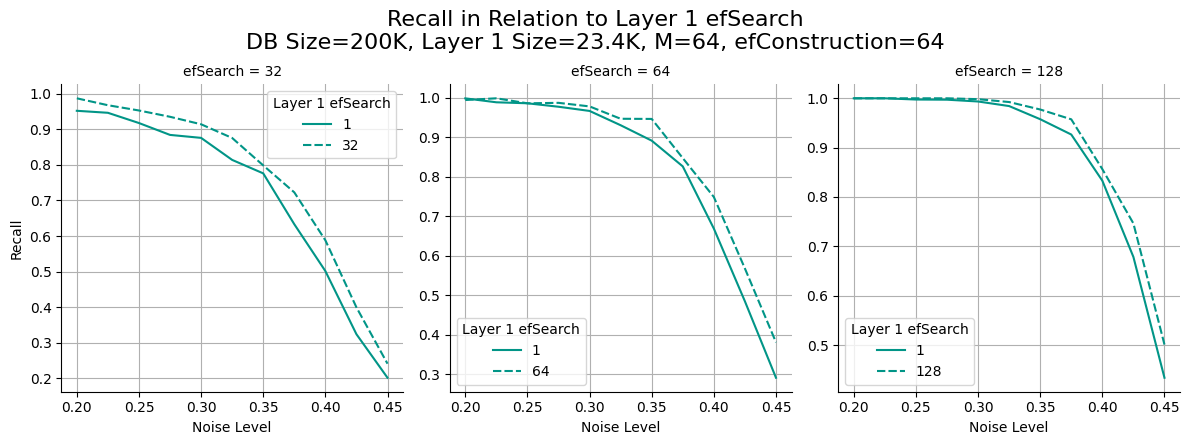

In [50]:
facetgrid = sns.FacetGrid(precision_df, col='efSearch', height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x='Noise Level', y='Recall', style='Layer 1 efSearch', color='#019587')
[(ax.grid(), ax.legend(title='Layer 1 efSearch', title_fontsize='10')) for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle(f"Recall in Relation to Layer 1 efSearch\nDB Size={int_to_scaled_string(db_size)}, Layer 1 Size={layer_1_expected_size}, M={M}, efConstruction={efConstruction}", fontsize=16, y=1.1)
plt.show()

In [57]:
computations = (
    final_df.groupby(['noise_level', 'efSearch', 'layer1_efSearch', 'experiment'])[['step', 'total_num_steps']]
    .last()
    .reset_index()
    .rename(columns={'noise_level':'Noise Level', 'layer1_efSearch':'Layer 1 efSearch', 'step':'Until Found', 'total_num_steps':'Total'})
    .melt(id_vars=['Noise Level', 'efSearch', 'Layer 1 efSearch', 'experiment'], value_vars=['Until Found', 'Total'], var_name='Steps', value_name='Count')
)

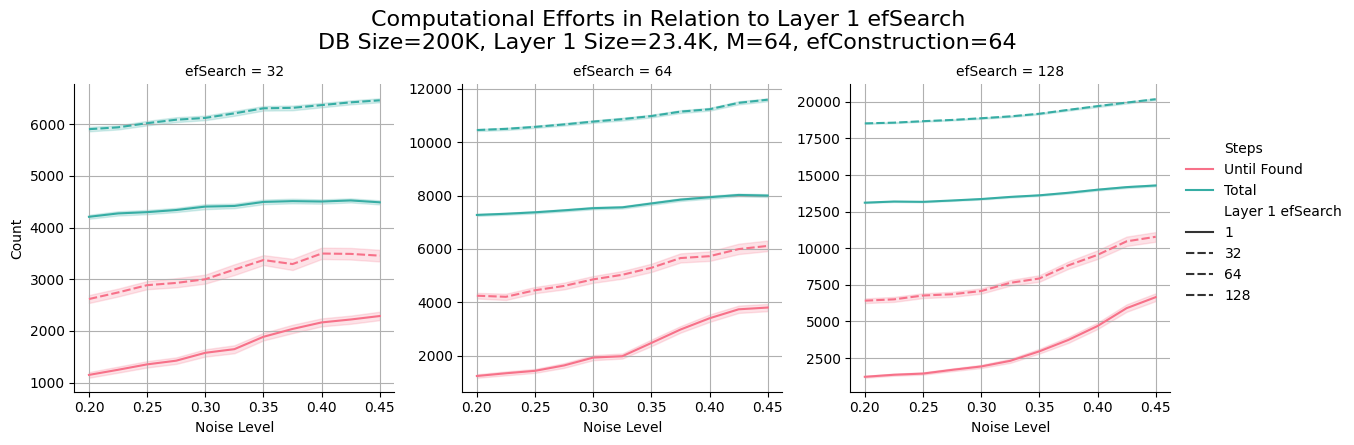

In [67]:
facetgrid = sns.FacetGrid(computations, col='efSearch', height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x='Noise Level', y='Count', hue='Steps', palette='husl', style='Layer 1 efSearch')
facetgrid.add_legend()
[ax.grid() for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle(f"Computational Efforts in Relation to Layer 1 efSearch\nDB Size={int_to_scaled_string(db_size)}, Layer 1 Size={layer_1_expected_size}, M={M}, efConstruction={efConstruction}", fontsize=16, y=1.1)
plt.show()

In [20]:
columns_lst = ['noise_level', 'efSearch', 'layer1_efSearch', 'experiment', 'single_step_progress', 'node_id', 'lc', 'target_node_id']
final_df = pd.read_parquet("temp_ef_results.parquet", columns=columns_lst)

In [21]:
final_df['curr_source_node'] = np.nan
for name, group in final_df.groupby(['noise_level', 'efSearch', 'layer1_efSearch', 'experiment']):
    sources = np.where(group['single_step_progress'].shift() > 0, group['node_id'], np.nan)
    filled_sources = pd.Series(data=sources, index=group.index).ffill()
    final_df.loc[group.index, 'curr_source_node'] = filled_sources

In [28]:
progress_df = (
    final_df[final_df['lc'] == 0]
    .groupby(['noise_level', 'efSearch', 'layer1_efSearch', 'experiment', 'curr_source_node'], sort=False)['target_node_id']
    .first()
    .reset_index()
)
progress_df['depth'] = progress_df.groupby(['noise_level', 'efSearch', 'layer1_efSearch', 'experiment']).cumcount()

In [22]:
# def get_single_experiment_distances_df(group):
#     distances_df_lst = []
#     for index, (experiment, layer_1_size, curr_source_node, target_node_id, depth) in group.iterrows():
#         source_neighbors = [tup[1] for tup in db.layers[0][int(curr_source_node)]]
#         distances = [int_distance(db.vectors[int(target_node_id)], db.vectors[neighbor]) for neighbor in source_neighbors]
#         distances_df_lst.append(pd.DataFrame({'Distances':distances, 'Depth':depth}))
#     return pd.concat(distances_df_lst)

In [112]:
distances_df = (
    progress_df
    .groupby(['experiment', 'noise_level', 'efSearch', 'layer1_efSearch'])
    .apply(get_single_experiment_distances_df)
    .droplevel(-1)
    .reset_index()
    .rename(columns={'noise_level':'Noise Level', 'layer1_efSearch':'Layer 1 efSearch'})
)
distances_df = distances_df[distances_df['Distances'] > 0]
distances_df['Depth'] = distances_df['Depth'].astype(int)

/var/folders/9g/pshnfl_53rv2t0zccy8bcr_m0000gn/T/ipykernel_85512/1379666536.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_single_experiment_distances_df)


In [116]:
def plot_hist_with_stats(data, **kwargs):
    sns.histplot(data, x="Distances", stat="probability", kde=True, **kwargs)
    mean, std = data["Distances"].mean(), data["Distances"].std()
    layer_1_size = data['Layer 1 Size'].iloc[0]
    plt.gca().set_title(f"Layer 1 Size = {layer_1_size}\nMean: {mean:.2f}, Std: {std:.2f}")

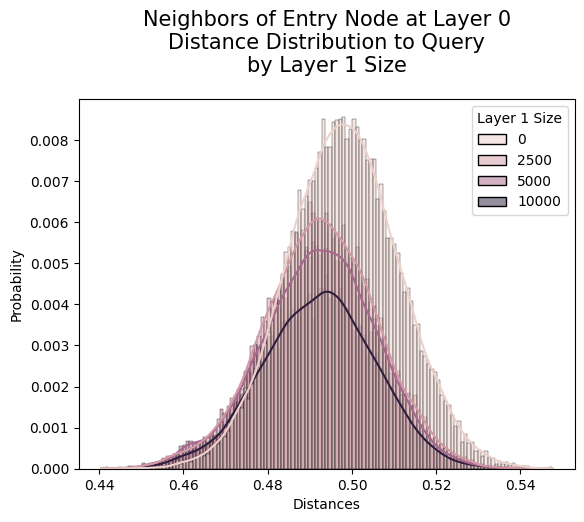

In [122]:
sns.histplot(distances_df[distances_df['Depth'] == 0], x='Distances', hue='Layer 1 Size', stat='probability', kde=True)
plt.title('Neighbors of Entry Node at Layer 0\nDistance Distribution to Query\nby Layer 1 Size', fontsize=15, y=1.05);

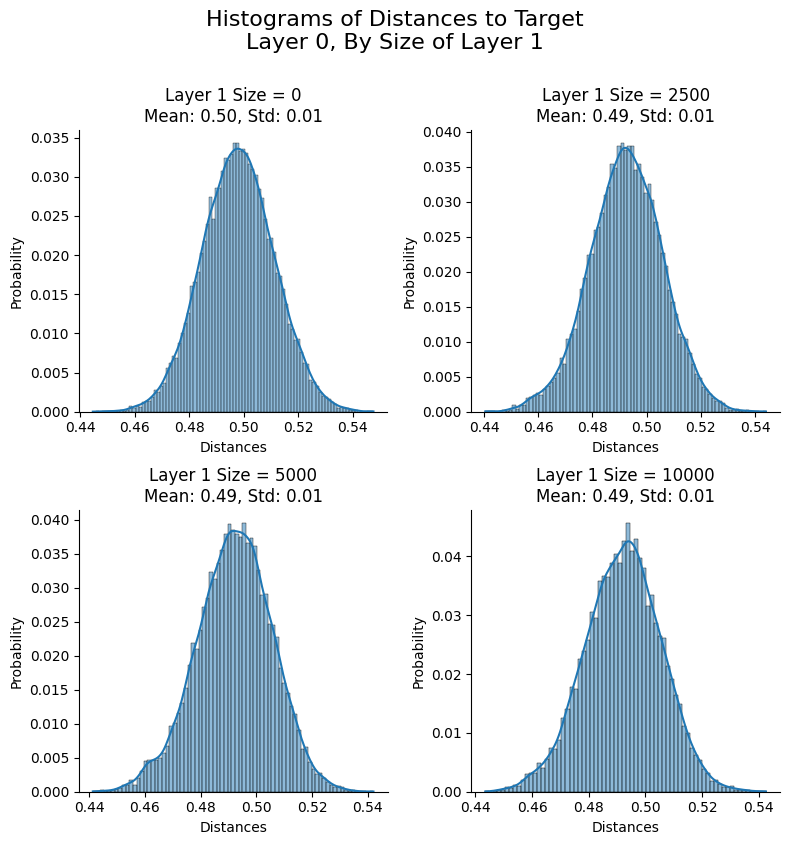

In [123]:
facetgrid = sns.FacetGrid(distances_df[distances_df['Depth'] == 0], col="Layer 1 Size", col_wrap=2, height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(plot_hist_with_stats)
facetgrid.fig.suptitle("Histograms of Distances to Target\nLayer 0, By Size of Layer 1", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()

# Notion Plots

## First Plot

### Configurations

In [17]:
synthetic_data_size = 2**22
max_tested_db_size = 101000

In [18]:
path_masks = f'synthetic_data/{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = 'synthetic_data/2_23_voter_arrays_90k_b090.dat'
path_iris_high = 'synthetic_data/2_23_voter_arrays_14k_b010.dat'

In [19]:
M = 64
efConstruction = 64
m_L = 1/np.log(M**8)
num_experiments = 1000

### Loading

In [20]:
loaded_masks = load_and_reshape_masks(path_masks, max_tested_db_size).astype(bool)
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, max_tested_db_size)

In [21]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)

In [22]:
iris_df['Inserted'] = False
db100K = hnsw.HNSW(
    M=M, 
    efConstruction=efConstruction, 
    m_L=m_L, 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)
update_db(db100K, iris_df, 100000)
db100K.record_search_log = True

Currently building 100K DB, with M=64, efConstruction=64. Insertion Progress: 100.0%                                                                                                                    

In [23]:
iris_df['Inserted'] = False
db10K = hnsw.HNSW(
    M=M, 
    efConstruction=efConstruction, 
    m_L=m_L, 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)
update_db(db10K, iris_df, 10000)
db10K.record_search_log = True

Currently building 10K DB, with M=64, efConstruction=64. Insertion Progress: 99.9%                                                                                                                      

### Plots

In [24]:
def get_distance_to_neighbor_distribution(db, num_experiments, efSearch=128):
    curr_db_size = db.get_stats()['db_size']
    indices, irises = iris_df['Template'].iloc[curr_db_size:curr_db_size+num_experiments].reset_index().T.values
    distances = []
    for new_iris in irises:
        new_query = make_query(new_iris)
        res = db.search(new_query, 1, ef=efSearch)
        res_neighbors = [tup[1] for tup in db.layers[0][res[0][1]]]
        distances.extend([int_distance(query_to_vector(new_query), db.vectors[neighbor]) for neighbor in res_neighbors])
    return distances

In [80]:
distances10K = get_distance_to_neighbor_distribution(db10K, 100)
distances100K = get_distance_to_neighbor_distribution(db100K, 100)

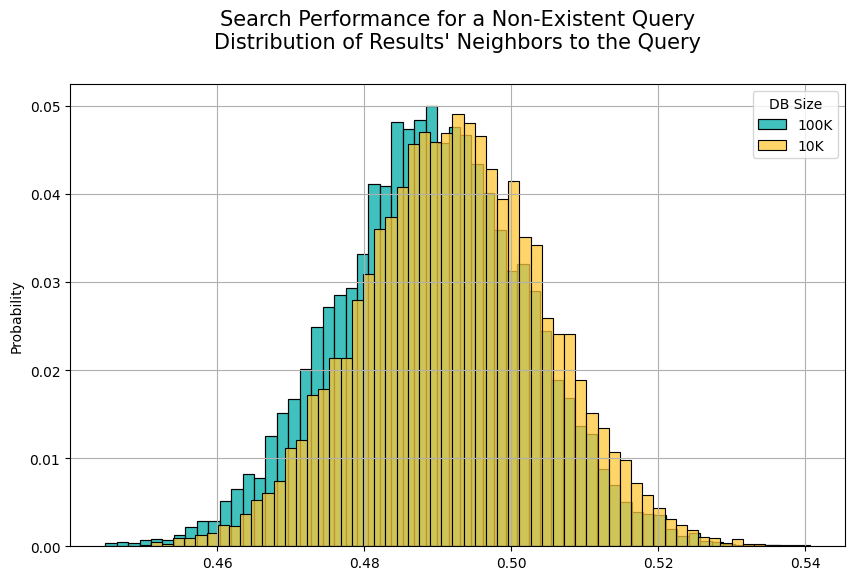

In [92]:
plt.figure(figsize=(10,6))
sns.histplot(distances100K, stat='probability', label='100K', color='#00ADA9')
sns.histplot(distances10K, stat='probability', label='10K', color='#FFC636')
plt.title("Search Performance for a Non-Existent Query\nDistribution of Results' Neighbors to the Query", fontsize=15, y=1.06)
plt.grid()
plt.legend(title='DB Size')

In [25]:
indices, irises = iris_df['Template'].iloc[:100000].sample(1000).reset_index().T.values
overlap_list = []
for idx, iris in zip(indices, irises):
    neighbors = [tup[1] for tup in db100K.layers[0][idx]]
    random_neighbor = random.choice(neighbors)
    random_neighbor_neighbors = [tup[1] for tup in db100K.layers[0][random_neighbor]]
    max_overlap = np.max([len(neighbors), len(random_neighbor_neighbors)])
    overlap_list.append(len(set(neighbors) & set(random_neighbor_neighbors)) / max_overlap)

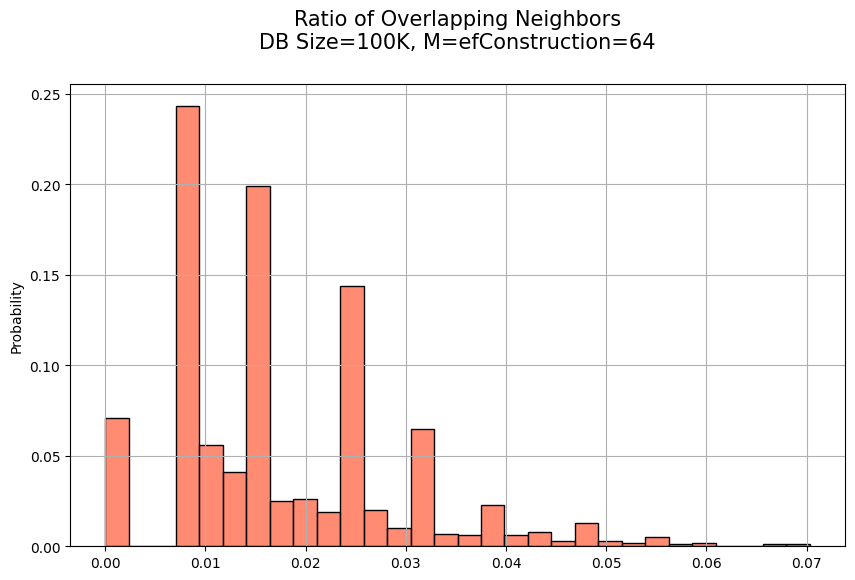

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(overlap_list, stat='probability', color='#FF6444', bins=30)
plt.title("Ratio of Overlapping Neighbors\nDB Size=100K, M=efConstruction=64", fontsize=15, y=1.06)
plt.grid()

In [114]:
# (idx1, idx2), (iris1, iris2) = iris_df['Template'].iloc[:100000].sample(2).reset_index().T.values
# iris1_query, iris2_query = make_query(iris1), make_query(iris2)
# iris1_neighbors = [tup[1] for tup in db100K.layers[0][idx1]]
# iris2_neighbors = [tup[1] for tup in db100K.layers[0][idx2]]
# iris1_neighbors_distances = [int_distance(query_to_vector(iris2_query), db100K.vectors[neighbor]) for neighbor in iris1_neighbors]
# iris2_neighbors_distances = [int_distance(query_to_vector(iris1_query), db100K.vectors[neighbor]) for neighbor in iris2_neighbors]
# distances = iris1_neighbors_distances + iris2_neighbors_distances

## Second Plot

### Configurations

In [15]:
synthetic_data_size = 2**22
max_tested_db_size = 225000

In [16]:
path_masks = f'synthetic_data/{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = 'synthetic_data/2_23_voter_arrays_90k_b090.dat'
path_iris_high = 'synthetic_data/2_23_voter_arrays_14k_b010.dat'

In [17]:
M = 64
efConstruction = 64

### Loading

In [18]:
loaded_masks = load_and_reshape_masks(path_masks, max_tested_db_size).astype(bool)
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, max_tested_db_size)
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)

In [23]:
db = hnsw.HNSW(
    M=M, 
    efConstruction=efConstruction, 
    m_L=1/np.log(M), 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)
update_db(db, iris_df, 200000, force_layer=0)
db.record_search_log = True

Currently building 200K DB, with M=64, efConstruction=64. Insertion Progress: 100.0%                                                                                                                    

In [26]:
results_path = 'layer1_analysis_df.parquet'
num_experiments, results_lst = 1000, []
for db_size in np.arange(200000, 225001, 1000):
    update_db(db, iris_df, db_size, force_layer=1)
    for efSearch in np.arange(16, 129, 8): 
        indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values            
        for i in range(num_experiments):
            print_progress(f'DB Size={int_to_scaled_string(db_size)}, efSearch={efSearch}, Search progress: {(i+1)/(num_experiments+1):.1%}')
            noisy_query = make_query(iris_with_noise(irises[i], noise_level=0.4))
            res = db.search(noisy_query, 1, ef={0:efSearch, 1:efSearch})
            recall = any(indices[i] == tup[1] for tup in res)
            results_lst.append((db_size-200000, efSearch, len(db.search_log), recall, i))
            
        results_df = pd.DataFrame(results_lst, columns=['Layer 1 Size', 'efSearch', 'Total Computations', 'Recall', 'Experiment'])
        results_df.to_parquet(results_path) 

DB Size=225K, efSearch=128, Search progress: 99.4%                                                                                                                                                      

In [33]:
def get_m_L(layer1_size, layer0_size):
    f = layer1_size / layer0_size
    def equation(m_L):
        return np.exp(-1/m_L) - np.exp(-2/m_L) - f
    
    # Solve for m_L using a root-finding method
    result = root_scalar(equation, bracket=[-0.1, 1], method='brentq')  # Bracket values chosen to ensure valid m_L
    if result.converged:
        return result.root
    else:
        raise ValueError("Root finding did not converge")

In [31]:
results_df['m_L'] = results_df['Layer 1 Size'].apply(lambda layer1_size: get_m_L(layer1_size, 200000))
min_m_L, max_m_L = results_df['m_L'].agg({'min', 'max'})

### Plots

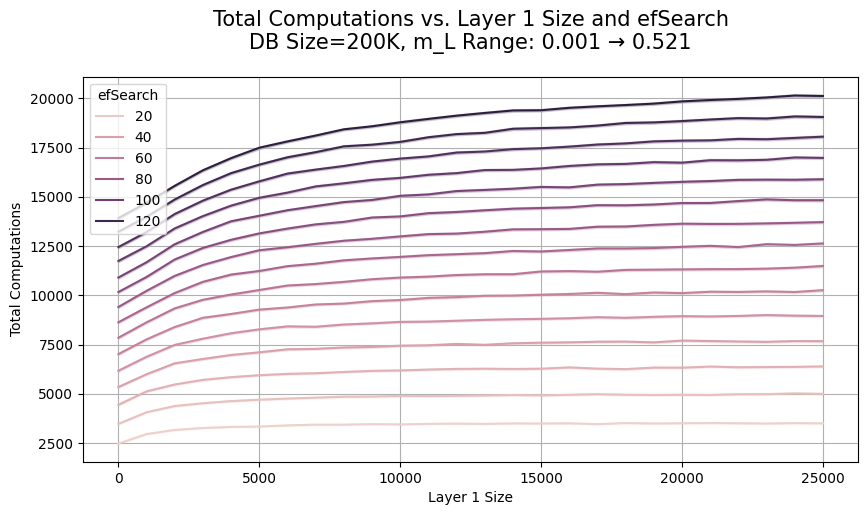

In [68]:
plt.figure(figsize=(10,5))
sns.lineplot(results_df, x='Layer 1 Size', y='Total Computations', hue='efSearch')
plt.grid()
plt.title(
    f"Total Computations vs. Layer 1 Size and efSearch\n"
    f"DB Size=200K, m_L Range: {min_m_L:.3f} → {max_m_L:.3f}", 
    fontsize=15, y=1.05
)
plt.show()

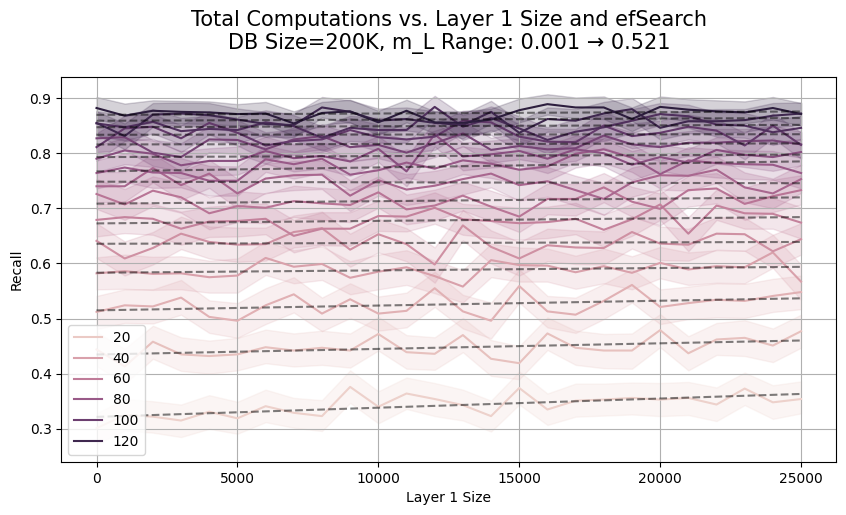

In [83]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='Layer 1 Size', y='Recall', hue='efSearch')
plt.grid()

coefs_list = []
for ef in results_df['efSearch'].unique():
    subset = results_df[results_df['efSearch'] == ef]
    x = subset['Layer 1 Size']
    y = subset['Recall']
    
    coef = np.polyfit(x, y, 1)
    coefs_list.append(coef)
    linear_approx = np.poly1d(coef)
    plt.plot(x, linear_approx(x), ls='--', color='k', alpha=0.5)
coefs_df = pd.DataFrame(coefs_list, columns=['Slope', 'Intercept'])
plt.title(
    f"Total Computations vs. Layer 1 Size and efSearch\n"
    f"DB Size=200K, m_L Range: {min_m_L:.3f} → {max_m_L:.3f}", 
    fontsize=15, y=1.05
)
plt.legend()
plt.show()